In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from scipy.special import wofz
from scipy.optimize import curve_fit
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": 12,
})


In [105]:
## Set up calibration
cal_date = "1001"
with open(f"cal_functions/{cal_date}.pkl", "rb") as f:
    cal = pickle.load(f)

cal_func = cal["function"]

In [ ]:
## choose data file
DIR = "/Users/charlottemyers/projects/jlab/spectro/data/"
files = ["Nate_Charlotte_1001_Run1.txt",
            "Nate_Charlotte_1001_Run2.txt",
            "Nate_Charlotte_1001_Run3.txt",
            "Nate_Charlotte_1001_Run4.txt",
            "Nate_Charlotte_1001_Run5.txt",
            "Nate_Charlotte_1001_Run6.txt",
            "Nate_Charlotte_1001_Run7.txt"]

run = 3
line = 6
path = DIR + files[run -1]

info = {
    "3": {"wl_range": (6560, 6566), "line_label": "Hα", "line": 6562.79},
    "4": {"wl_range": (4859.5, 4863), "line_label": "Hβ", "line": 4861.35},
    "5": {"wl_range": (4338.5, 4342), "line_label": "Hγ", "line": 4340.47},

    "6": {"wl_range": (4099.5, 4103), "line_label": "Hδ", "line": 4101.74},
}

['step', 'Monochromator-step', 'cps']
3900.0 4800.0


(4099.5, 4103.0)

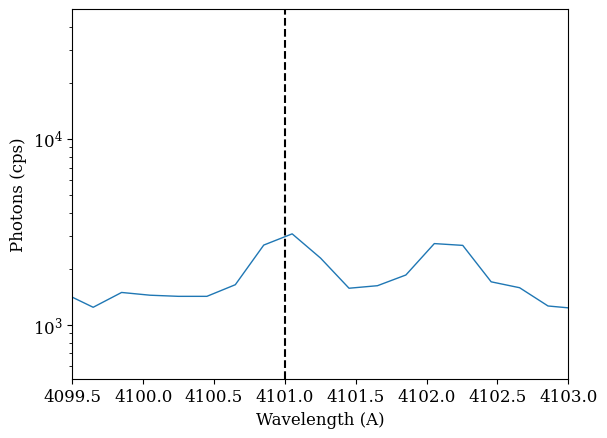

In [330]:
df = pd.read_csv(path, sep=r"\s+")
#df = df.iloc[:, [1, 2]].rename(columns={df.columns[0]: "step", df.columns[1]: "cps"})
print(df.columns.tolist())

step = df["Monochromator-step"].to_numpy()
wl = cal_func(step)
cps  = df["cps"].to_numpy()

plt.plot(wl, cps, lw=1, label = path.split("/")[-1])
plt.xlabel("Wavelength (A)")
plt.ylabel("Photons (cps)")
plt.yscale("log")

print(min(step), max(step))
plt.axvline(4861, color="k", ls="--", label="Hβ")


plt.axvline(4101, color="k", ls="--")
#plt.xlim(4095, 4110)
plt.xlim(info[str(line)]["wl_range"])

#plt.xlim(4000, 4110)

In [331]:


def voigt(x, mu, sigma, gamma):
    # normalized Voigt profile
    z = ((x - mu) + 1j*gamma) / (sigma * np.sqrt(2))
    return np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))

def two_voigts(x, A_H, mu_H, A_D, mu_D, sigma, gamma, C):
    return A_H*voigt(x, mu_H, sigma, gamma) + A_D*voigt(x, mu_D, sigma, gamma) + C

def two_gaussians(x, A_H, mu_H, A_D, mu_D, sigma, C):
    return A_H*np.exp(-(x - mu_H)**2 / (2*sigma**2)) + A_D*np.exp(-(x - mu_D)**2 / (2*sigma**2)) + C

Δλ = 1.79449 ± 0.00930 A
Δv = 81.97 ± 0.42 km/s
Gaussian fit: Δλ = 1.78017 ± 0.32350 A
Gaussian fit: Δv = 81.31 ± 14.78 km/s

Voigt Fit Parameters:
A_H  = 61400.9 ± 1664.8 cps
mu_H = 6563.4599 ± 0.0026 A
A_D  = 18005.4 ± 794.8 cps
mu_D = 6561.6654 ± 0.0089 A
sigma = 0.2020 ± 0.0087 A


Text(0, 0.5, 'Photons (cps)')

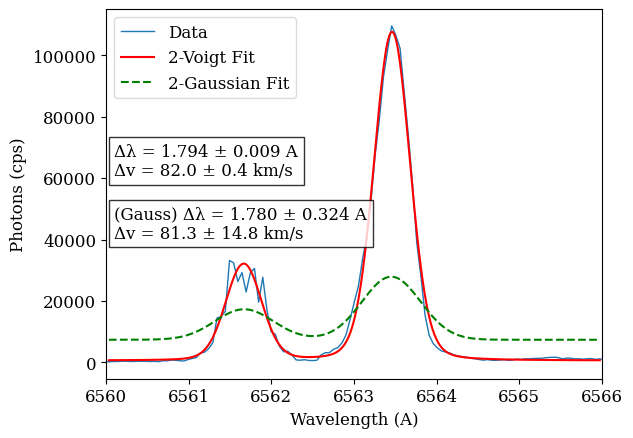

In [ ]:
run = 2
line = 3
path = DIR + files[run -1]

df = pd.read_csv(path, sep=r"\s+")
step = df["Monochromator-step"].to_numpy()
wl = cal_func(step)
cps  = df["cps"].to_numpy()


mask = (wl > info[str(line)]["wl_range"][0]) & (wl < info[str(line)]["wl_range"][1])
xw = wl[mask]
yw = cps[mask]
muH0 =  info[str(line)]["line"]
muD0 = muH0 - 1.18
AH0  = yw.max()
AD0  = yw.max()
sigma0 = 0.2
gamma0 = 0.00
C0 = np.median(yw[:10])

bounds = (
    [0,      muH0-2, 0,      muH0-6, 0, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+2, 2, 0.1, np.inf]  # upper (tune)
)


p0 = [AH0, muH0, AD0, muD0, sigma0, gamma0, C0]

popt, pcov = curve_fit(two_voigts, xw, yw, p0=p0, bounds=bounds, maxfev=20000)
AH, muH, AD, muD, sigma, gamma, C = popt
perr = np.sqrt(np.diag(pcov))

dlam = muH - muD
# uncertainty via covariance (muH index 1, muD index 3)
var_dlam = pcov[1,1] + pcov[3,3] - 2*pcov[1,3]
sd_dlam = np.sqrt(max(var_dlam, 0.0))


# velocity splitting (use line center)
c_kms = 299792.458
vsplit = c_kms * dlam / muH
sv_vsplit = c_kms * sd_dlam / muH
print(f"Δλ = {dlam:.5f} ± {sd_dlam:.5f} A")
print(f"Δv = {vsplit:.2f} ± {sv_vsplit:.2f} km/s")

# plot fit
xf = np.linspace(xw.min(), xw.max(), 500)
yf = two_voigts(xf, *popt)
plt.plot(wl, cps, lw=1, label = "Data")
plt.plot(xf, yf, 'r-', label="2-Voigt Fit")

# annotate TEXT with true and expected splittings
text_x = info[str(line)]["wl_range"][0] + 0.1
text_y = yw.max()/1.8
plt.text(text_x, text_y, f"Δλ = {dlam:.3f} ± {sd_dlam:.3f} A\nΔv = {vsplit:.1f} ± {sv_vsplit:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))


######## GAUSSIAN FIT
p0g = [AH0, muH0, AD0, muD0, sigma0, C0]
boundsg = (
    [0, muH0-2, 0, muH0-5, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+2, 2, np.inf]
)
poptg, pcovg = curve_fit(two_gaussians, xw, yw, p0=p0g, bounds=boundsg, maxfev=20000)
AHg, muHg, ADg, muDg, sigmag, Cg = poptg
perrg = np.sqrt(np.diag(pcovg))
dlamg = muHg - muDg
var_dlamg = pcovg[1,1] + pcovg[3,3] - 2*pcovg[1,3]
sd_dlamg = np.sqrt(max(var_dlamg, 0.0))
vsplitg = c_kms * dlamg / muHg
sv_vsplitg = c_kms * sd_dlamg / muHg
print(f"Gaussian fit: Δλ = {dlamg:.5f} ± {sd_dlamg:.5f} A")
print(f"Gaussian fit: Δv = {vsplitg:.2f} ± {sv_vsplitg:.2f} km/s")
yfg = two_gaussians(xf, *poptg)
plt.plot(xf, yfg, 'g--', label="2-Gaussian Fit")
# annotation TEXT
plt.text(text_x, text_y/1.5, f"(Gauss) Δλ = {dlamg:.3f} ± {sd_dlamg:.3f} A\nΔv = {vsplitg:.1f} ± {sv_vsplitg:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))
#######

# print all fit parameters
print("\nVoigt Fit Parameters:")
print(f"A_H  = {AH:.1f} ± {perr[0]:.1f} cps")
print(f"mu_H = {muH:.4f} ± {perr[1]:.4f} A")
print(f"A_D  = {AD:.1f} ± {perr[2]:.1f} cps")
print(f"mu_D = {muD:.4f} ± {perr[3]:.4f} A")
print(f"sigma = {sigma:.4f} ± {perr[4]:.4f} A")

#####
plt.legend(framealpha = 0.7, loc = "upper left")
plt.xlim(info[str(line)]["wl_range"])
plt.xlabel("Wavelength (A)")
plt.ylabel("Photons (cps)")

4861.8
Δλ = 1.35890 ± 0.00191 A
Δv = 83.79 ± 0.12 km/s
Gaussian fit: Δλ = 1.35857 ± 0.00187 A
Gaussian fit: Δv = 83.77 ± 0.12 km/s

Voigt Fit Parameters:
A_H  = 16369.9 ± 301.5 cps
mu_H = 4861.8083 ± 0.0014 A
A_D  = 18502.5 ± 329.3 cps
mu_D = 4860.4494 ± 0.0013 A
sigma = 0.2086 ± 0.0037 A


Text(0, 0.5, 'Photons (cps)')

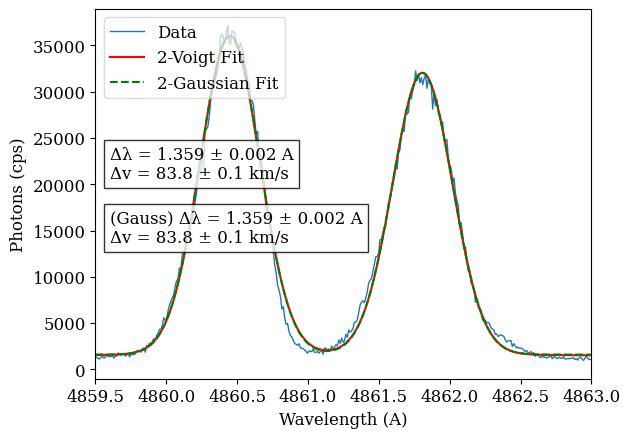

In [ ]:
run = 7
line = 4
path = DIR + files[run -1]

df = pd.read_csv(path, sep=r"\s+")
step = df["Monochromator-step"].to_numpy()
wl = cal_func(step)
cps  = df["cps"].to_numpy()


#mask = (wl > 6560) & (wl < 6565)
mask = (wl > info[str(line)]["wl_range"][0]) & (wl < info[str(line)]["wl_range"][1])
#mask = (wl > 4338) & (wl < 4342)  # Hγ
xw = wl[mask]
yw = cps[mask]

# crude initial guesses
muH0 =  4861.8
muD0 = muH0 - 1.18
AH0  = yw.max()
AD0  = yw.max()
sigma0 = 0.2
gamma0 = 0.00
C0 = np.median(yw[:10])

bounds = (
    [0,      muH0-2, 0,      muH0-6, 0, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+2, 2, 0.1, np.inf]  # upper (tune)
)


p0 = [AH0, muH0, AD0, muD0, sigma0, gamma0, C0]

popt, pcov = curve_fit(two_voigts, xw, yw, p0=p0, bounds=bounds, maxfev=20000)
AH, muH, AD, muD, sigma, gamma, C = popt
perr = np.sqrt(np.diag(pcov))

dlam = muH - muD
# uncertainty via covariance (muH index 1, muD index 3)
var_dlam = pcov[1,1] + pcov[3,3] - 2*pcov[1,3]
sd_dlam = np.sqrt(max(var_dlam, 0.0))




# velocity splitting (use line center)
c_kms = 299792.458
vsplit = c_kms * dlam / muH
sv_vsplit = c_kms * sd_dlam / muH
print(f"Δλ = {dlam:.5f} ± {sd_dlam:.5f} A")
print(f"Δv = {vsplit:.2f} ± {sv_vsplit:.2f} km/s")

# plot fit
xf = np.linspace(xw.min(), xw.max(), 500)
yf = two_voigts(xf, *popt)
plt.plot(wl, cps, lw=1, label = "Data")
plt.plot(xf, yf, 'r-', label="2-Voigt Fit")

# annotate TEXT with true and expected splittings
text_x = info[str(line)]["wl_range"][0] + 0.1
text_y = yw.max()/1.8
plt.text(text_x, text_y, f"Δλ = {dlam:.3f} ± {sd_dlam:.3f} A\nΔv = {vsplit:.1f} ± {sv_vsplit:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))


######## GAUSSIAN FIT
p0g = [AH0, muH0, AD0, muD0, sigma0, C0]
boundsg = (
    [0, muH0-2, 0, muH0-5, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+2, 2, np.inf]
)
poptg, pcovg = curve_fit(two_gaussians, xw, yw, p0=p0g, bounds=boundsg, maxfev=20000)
AHg, muHg, ADg, muDg, sigmag, Cg = poptg
perrg = np.sqrt(np.diag(pcovg))
dlamg = muHg - muDg
var_dlamg = pcovg[1,1] + pcovg[3,3] - 2*pcovg[1,3]
sd_dlamg = np.sqrt(max(var_dlamg, 0.0))
vsplitg = c_kms * dlamg / muHg
sv_vsplitg = c_kms * sd_dlamg / muHg
print(f"Gaussian fit: Δλ = {dlamg:.5f} ± {sd_dlamg:.5f} A")
print(f"Gaussian fit: Δv = {vsplitg:.2f} ± {sv_vsplitg:.2f} km/s")
yfg = two_gaussians(xf, *poptg)
plt.plot(xf, yfg, 'g--', label="2-Gaussian Fit")
# annotation TEXT
plt.text(text_x, text_y/1.5, f"(Gauss) Δλ = {dlamg:.3f} ± {sd_dlamg:.3f} A\nΔv = {vsplitg:.1f} ± {sv_vsplitg:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))
#######

# print all fit parameters
print("\nVoigt Fit Parameters:")
print(f"A_H  = {AH:.1f} ± {perr[0]:.1f} cps")
print(f"mu_H = {muH:.4f} ± {perr[1]:.4f} A")
print(f"A_D  = {AD:.1f} ± {perr[2]:.1f} cps")
print(f"mu_D = {muD:.4f} ± {perr[3]:.4f} A")
print(f"sigma = {sigma:.4f} ± {perr[4]:.4f} A")

#####
plt.legend(framealpha = 0.7, loc = "upper left")
plt.xlim(info[str(line)]["wl_range"])
plt.xlabel("Wavelength (A)")
plt.ylabel("Photons (cps)")


Δλ = 1.17749 ± 0.00300 A
Δv = 81.32 ± 0.21 km/s
Gaussian fit: Δλ = 1.17749 ± 0.00283 A
Gaussian fit: Δv = 81.32 ± 0.20 km/s

Voigt Fit Parameters:
A_H  = 2428.9 ± 58.2 cps
mu_H = 4340.8645 ± 0.0023 A
A_D  = 2903.9 ± 66.9 cps
mu_D = 4339.6870 ± 0.0019 A
sigma = 0.2139 ± 0.0059 A


Text(0, 0.5, 'Photons (cps)')

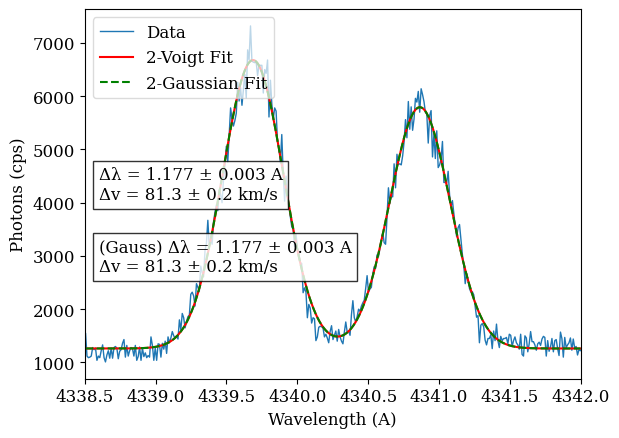

In [265]:
run = 6
line = 5
path = DIR + files[run -1]

df = pd.read_csv(path, sep=r"\s+")
step = df["Monochromator-step"].to_numpy()
wl = cal_func(step)
cps  = df["cps"].to_numpy()

mask = (wl > info[str(line)]["wl_range"][0]) & (wl < info[str(line)]["wl_range"][1])
xw = wl[mask]
yw = cps[mask]

muH0 = info[str(line)]["line"]
muD0 = muH0 - 1.18
AH0  = yw.max()
AD0  = yw.max()
sigma0 = 0.2
gamma0 = 0.00
C0 = np.median(yw[:10])

bounds = (
    [0,      muH0-2, 0,      muH0-6, 0, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+2, 2, 0.1, np.inf]  # upper (tune)
)


p0 = [AH0, muH0, AD0, muD0, sigma0, gamma0, C0]

popt, pcov = curve_fit(two_voigts, xw, yw, p0=p0, bounds=bounds, maxfev=20000)
AH, muH, AD, muD, sigma, gamma, C = popt
perr = np.sqrt(np.diag(pcov))

dlam = muH - muD
# uncertainty via covariance (muH index 1, muD index 3)
var_dlam = pcov[1,1] + pcov[3,3] - 2*pcov[1,3]
sd_dlam = np.sqrt(max(var_dlam, 0.0))




# velocity splitting (use line center)
c_kms = 299792.458
vsplit = c_kms * dlam / muH
sv_vsplit = c_kms * sd_dlam / muH
print(f"Δλ = {dlam:.5f} ± {sd_dlam:.5f} A")
print(f"Δv = {vsplit:.2f} ± {sv_vsplit:.2f} km/s")

# plot fit
xf = np.linspace(xw.min(), xw.max(), 500)
yf = two_voigts(xf, *popt)
plt.plot(wl, cps, lw=1, label = "Data")
plt.plot(xf, yf, 'r-', label="2-Voigt Fit")

# annotate TEXT with true and expected splittings
text_x = info[str(line)]["wl_range"][0] + 0.1
text_y = yw.max()/1.8
plt.text(text_x, text_y, f"Δλ = {dlam:.3f} ± {sd_dlam:.3f} A\nΔv = {vsplit:.1f} ± {sv_vsplit:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))


######## GAUSSIAN FIT
p0g = [AH0, muH0, AD0, muD0, sigma0, C0]
boundsg = (
    [0, muH0-2, 0, muH0-5, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+2, 2, np.inf]
)
poptg, pcovg = curve_fit(two_gaussians, xw, yw, p0=p0g, bounds=boundsg, maxfev=20000)
AHg, muHg, ADg, muDg, sigmag, Cg = poptg
perrg = np.sqrt(np.diag(pcovg))
dlamg = muHg - muDg
var_dlamg = pcovg[1,1] + pcovg[3,3] - 2*pcovg[1,3]
sd_dlamg = np.sqrt(max(var_dlamg, 0.0))
vsplitg = c_kms * dlamg / muHg
sv_vsplitg = c_kms * sd_dlamg / muHg
print(f"Gaussian fit: Δλ = {dlamg:.5f} ± {sd_dlamg:.5f} A")
print(f"Gaussian fit: Δv = {vsplitg:.2f} ± {sv_vsplitg:.2f} km/s")
yfg = two_gaussians(xf, *poptg)
plt.plot(xf, yfg, 'g--', label="2-Gaussian Fit")
# annotation TEXT
plt.text(text_x, text_y/1.5, f"(Gauss) Δλ = {dlamg:.3f} ± {sd_dlamg:.3f} A\nΔv = {vsplitg:.1f} ± {sv_vsplitg:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))
#######

# print all fit parameters
print("\nVoigt Fit Parameters:")
print(f"A_H  = {AH:.1f} ± {perr[0]:.1f} cps")
print(f"mu_H = {muH:.4f} ± {perr[1]:.4f} A")
print(f"A_D  = {AD:.1f} ± {perr[2]:.1f} cps")
print(f"mu_D = {muD:.4f} ± {perr[3]:.4f} A")
print(f"sigma = {sigma:.4f} ± {perr[4]:.4f} A")

#####
plt.legend(framealpha = 0.7, loc = "upper left")
plt.xlim(info[str(line)]["wl_range"])
plt.xlabel("Wavelength (A)")
plt.ylabel("Photons (cps)")

Δλ = 1.12936 ± 0.01949 A
Δv = 82.54 ± 1.42 km/s
Gaussian fit: Δλ = 1.12237 ± 0.01949 A
Gaussian fit: Δv = 82.02 ± 1.42 km/s

Voigt Fit Parameters:
A_H  = 835.7 ± 122.7 cps
mu_H = 4102.1428 ± 0.0147 A
A_D  = 996.8 ± 139.5 cps
mu_D = 4101.0135 ± 0.0125 A
sigma = 0.1561 ± 0.0389 A


Text(0, 0.5, 'Photons (cps)')

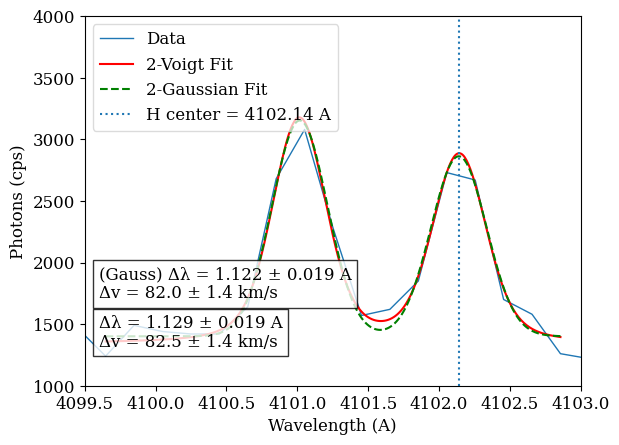

In [339]:
run = 3
line = 6
path = DIR + files[run -1]

df = pd.read_csv(path, sep=r"\s+")
step = df["Monochromator-step"].to_numpy()
wl = cal_func(step)
cps  = df["cps"].to_numpy()


mask = (wl > info[str(line)]["wl_range"][0]) & (wl < info[str(line)]["wl_range"][1])
xw = wl[mask]
yw = cps[mask]
muH0 =  info[str(line)]["line"]
muD0 = muH0 - 1.18
AH0  = yw.max()
AD0  = yw.max()
sigma0 = 0.5
gamma0 = 0.00
C0 = np.median(yw[:10])

bounds = (
    [0,      muH0-2, 0,      muH0-6, 0, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+1, 2, 0.1, np.inf]  # upper (tune)
)


p0 = [AH0, muH0, AD0, muD0, sigma0, gamma0, C0]

popt, pcov = curve_fit(two_voigts, xw, yw, p0=p0, bounds=bounds, maxfev=20000)
AH, muH, AD, muD, sigma, gamma, C = popt
perr = np.sqrt(np.diag(pcov))

dlam = muH - muD
# uncertainty via covariance (muH index 1, muD index 3)
var_dlam = pcov[1,1] + pcov[3,3] - 2*pcov[1,3]
sd_dlam = np.sqrt(max(var_dlam, 0.0))


# velocity splitting (use line center)
c_kms = 299792.458
vsplit = c_kms * dlam / muH
sv_vsplit = c_kms * sd_dlam / muH
print(f"Δλ = {dlam:.5f} ± {sd_dlam:.5f} A")
print(f"Δv = {vsplit:.2f} ± {sv_vsplit:.2f} km/s")

# plot fit
xf = np.linspace(xw.min(), xw.max(), 500)
yf = two_voigts(xf, *popt)
plt.plot(wl, cps, lw=1, label = "Data")
plt.plot(xf, yf, 'r-', label="2-Voigt Fit")

# annotate TEXT with true and expected splittings
text_x = info[str(line)]["wl_range"][0] + 0.1
text_y = yw.max()/1.8
plt.text(text_x, text_y/1.3, f"Δλ = {dlam:.3f} ± {sd_dlam:.3f} A\nΔv = {vsplit:.1f} ± {sv_vsplit:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))


######## GAUSSIAN FIT
p0g = [AH0, muH0, AD0, muD0, sigma0, C0]
boundsg = (
    [0, muH0-2, 0, muH0-5, 0, -np.inf],  # lower
    [np.inf, muH0+2, np.inf, muH0+2, 2, np.inf]
)
poptg, pcovg = curve_fit(two_gaussians, xw, yw, p0=p0g, bounds=boundsg, maxfev=20000)
AHg, muHg, ADg, muDg, sigmag, Cg = poptg
perrg = np.sqrt(np.diag(pcovg))
dlamg = muHg - muDg
var_dlamg = pcovg[1,1] + pcovg[3,3] - 2*pcovg[1,3]
sd_dlamg = np.sqrt(max(var_dlamg, 0.0))
vsplitg = c_kms * dlamg / muHg
sv_vsplitg = c_kms * sd_dlamg / muHg
print(f"Gaussian fit: Δλ = {dlamg:.5f} ± {sd_dlamg:.5f} A")
print(f"Gaussian fit: Δv = {vsplitg:.2f} ± {sv_vsplitg:.2f} km/s")
yfg = two_gaussians(xf, *poptg)
plt.plot(xf, yfg, 'g--', label="2-Gaussian Fit")
# annotation TEXT
plt.text(text_x, text_y, f"(Gauss) Δλ = {dlamg:.3f} ± {sd_dlamg:.3f} A\nΔv = {vsplitg:.1f} ± {sv_vsplitg:.1f} km/s",
         bbox=dict(facecolor='white', alpha=0.8))
#######

# mark center of H and D
plt.axvline(muH, color='tab:blue', ls=':', label=f'H center = {muH:.2f} A')

# print all fit parameters
print("\nVoigt Fit Parameters:")
print(f"A_H  = {AH:.1f} ± {perr[0]:.1f} cps")
print(f"mu_H = {muH:.4f} ± {perr[1]:.4f} A")
print(f"A_D  = {AD:.1f} ± {perr[2]:.1f} cps")
print(f"mu_D = {muD:.4f} ± {perr[3]:.4f} A")
print(f"sigma = {sigma:.4f} ± {perr[4]:.4f} A")

#####
plt.legend(framealpha = 0.7, loc = "upper left")
plt.xlim(info[str(line)]["wl_range"])
plt.ylim(1000, 4000)
plt.xlabel("Wavelength (A)")
plt.ylabel("Photons (cps)")


In [266]:


# # Normalized Voigt (unit area).
# def _voigt_norm(x, cen, sigma, gamma):
#     z = ((x - cen) + 1j*gamma) / (sigma*np.sqrt(2))
#     return np.real(wofz(z)) / (sigma*np.sqrt(2*np.pi))

# # Model: area*Voigt + linear baseline
# def voigt_model(x, area, cen, sigma, gamma, b0, b1):
#     return area * _voigt_norm(x, cen, sigma, gamma) + (b0 + b1*(x - cen))

# def fit_voigt_peak(step, cps, x0_rough, window=5.0, use_weights=True):
#     # --- window data around the line ---
#     m = (step >= x0_rough - window) & (step <= x0_rough + window)
#     x, y = step[m].astype(float), cps[m].astype(float)

#     # --- initial guesses ---
#     cen0 = x[np.argmax(y)]
#     ylo  = np.percentile(y, 10)
#     yhi  = y.max()
#     hm   = ylo + 0.5*(yhi - ylo)
#     try:
#         iL = np.where(y >= hm)[0][0]
#         iR = np.where(y >= hm)[0][-1]
#         fwhm0 = max( (x[iR] - x[iL]), 1e-3 )
#     except Exception:
#         fwhm0 = max(0.8, (x.max()-x.min())/6)  # fallback
#     sigma0 = max(fwhm0/2.355, 1e-3)
#     gamma0 = 0.5*sigma0
#     area0  = max((yhi - ylo) * sigma0 * np.sqrt(2*np.pi), 1e-6)
#     b0_0, b1_0 = float(ylo), 0.0

#     p0 = [area0, cen0, sigma0, gamma0, b0_0, b1_0]
#     bounds = (
#         [0.0, cen0 - window, 1e-6, 1e-6, -np.inf, -np.inf],
#         [np.inf, cen0 + window, window*2.0,  window*2.0,  np.inf,  np.inf],
#     )

#     sigma_y = None
#     if use_weights:
#         sigma_y = np.sqrt(np.clip(y, 1.0, None))  # Poisson-ish
#     popt, pcov = curve_fit(
#         voigt_model, x, y, p0=p0, bounds=bounds,
#         sigma=sigma_y, absolute_sigma=True, maxfev=20000
#     )
#     area, cen, sigma, gamma, b0, b1 = popt

#     # Approx Voigt FWHM (Olivero-Longbothum)
#     fwhm = 0.5346*(2*gamma) + np.sqrt(0.2166*(2*gamma)**2 + (2.355*sigma)**2)

#     # Plot
#     xf = np.linspace(x.min(), x.max(), 1000)
#     yf = voigt_model(xf, *popt)
#     plt.plot(x, y, lw=1, label="data")
#     plt.plot(xf, yf, ls="--", label="Voigt fit")

#     # annotate
#     txt = (f"cen={cen:.3f}  σ={sigma:.3f}  γ={gamma:.3f}\n"
#            f"FWHM≈{fwhm:.3f}  area={area:.2f}")
#     plt.text(0.02, 0.98, txt, transform=plt.gca().transAxes,
#              ha="left", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.8"))
#     plt.xlabel("Monochromator step (≈ Å)")
#     plt.ylabel("cps")
#     plt.legend(frameon=False)
#     plt.title("Voigt fit")
#     plt.xlim(x.min(), x.max())

#     return popt, pcov, {"FWHM": fwhm}

# # fit + plot
# x0_rough = 4339.5
# popt, pcov, extra = fit_voigt_peak(wl, cps, x0_rough, window=1.0, use_weights=True)
# peak_location1 = popt[1]
# print("peak location 1:", peak_location1)
# print("Fit parameters:", popt)

In [267]:
# # fit voigt to 2 adjacent peaks, extract the max as the peak centers
# x0_rough = 4341
# popt1, pcov1, extra1 = fit_voigt_peak(wl, cps, x0_rough, window=1.0, use_weights=True)

# peak_location2 = (popt1[1])
# print("Peak location:", peak_location2)

In [ ]:
# delta_lambda = peak_location1 - peak_location2
# print("Delta lambda (A):", delta_lambda)
# print("Expected delta lambda (A):", 0.17846254*10)

Delta lambda (A): -1.194414777750353
Expected delta lambda (A): 1.7846254


 n (Balmer)   λ_H (Å)  Δλ (Å)  m_D/m_p  σ(m_D/m_p)
          3 6563.4599   1.794 2.008644    0.007905
          4 4861.8083   1.359 2.055630    0.003194
          5 4340.8645   1.177 1.992561    0.005041
          6 4102.1400   1.122 2.010011    0.034378

Combined m_D/m_p = 2.034416 ± 0.002546
CODATA m_D/m_p   = 1.999008
Bias (combined − CODATA) = +0.035408


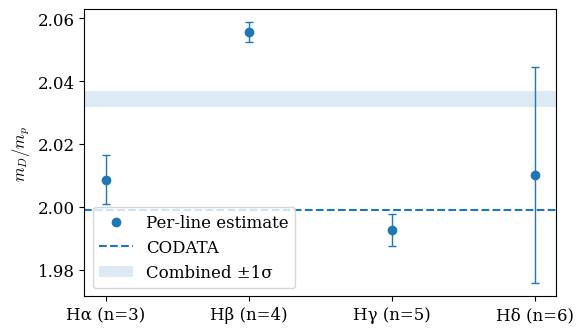

In [360]:

from scipy.constants import m_e, m_p, physical_constants

n    = np.array([3, 4, 5, 6])
lamH = np.array([6563.4599,4861.8083, 4340.8645, 4102.14]  )
dlam = np.array([1.794, 1.359, 1.177, 1.122])

sig_lamH = np.array([0.0026, 0.0014, 0.0023, 0.0147])
sig_dlam = np.array([0.007, 0.002, 0.003, 0.019])


eps = m_e / m_p  # dimensionless
md_over_mp_true = physical_constants["deuteron mass"][0] / m_p  # CODATA ratio

def md_over_mp_from_split(lH, dL):
    r = 1.0 - dL/lH
    return eps / (r*(1+eps) - 1.0)

def md_over_mp_err(lH, dL, sL, sD):
    # Propagate errors for r = 1 - dL/lH
    r = 1.0 - dL/lH
    dr = np.sqrt( (sD/lH)**2 + (dL*sL/lH**2)**2 )
    denom = r*(1+eps) - 1.0
    dmd_dr = -eps*(1+eps) / (denom**2)
    return abs(dmd_dr) * dr

# --- Compute per-line values ---
mdmp = np.array([md_over_mp_from_split(L, D) for L, D in zip(lamH, dlam)])

if (sig_lamH is not None) and (sig_dlam is not None):
    mdmp_err = np.array([md_over_mp_err(L, D, sL, sD)
                         for L, D, sL, sD in zip(lamH, dlam, sig_lamH, sig_dlam)])
else:
    mdmp_err = np.full_like(mdmp, np.nan, dtype=float)

# --- Combine (weighted by errors?) ---
if np.all(np.isfinite(mdmp_err)):
    w = 1.0 / np.square(mdmp_err)
    mdmp_comb = np.sum(w*mdmp) / np.sum(w)
    mdmp_comb_err = np.sqrt(1.0 / np.sum(w))
else:
    mdmp_comb = mdmp.mean()
    mdmp_comb_err = np.nan

# --- Table (nice to paste into slides) ---
df = pd.DataFrame({
    "n (Balmer)": n,
    r"λ_H (Å)": lamH,
    r"Δλ (Å)": dlam,
    r"m_D/m_p": mdmp,
    r"σ(m_D/m_p)": mdmp_err
})
print(df.to_string(index=False))

print("\nCombined m_D/m_p = "
      f"{mdmp_comb:.6f}" + (f" ± {mdmp_comb_err:.6f}" if np.isfinite(mdmp_comb_err) else ""))
print(f"CODATA m_D/m_p   = {md_over_mp_true:.6f}")
print(f"Bias (combined − CODATA) = {mdmp_comb - md_over_mp_true:+.6f}")

# --- Plot ---
plt.figure(figsize=(6,3.5))
x = np.arange(len(n))
plt.scatter(x, mdmp, label="Per-line estimate", zorder=3)
if np.all(np.isfinite(mdmp_err)):
    plt.errorbar(x, mdmp, yerr=mdmp_err, fmt='none', capsize=3, lw=1, zorder=2)

plt.axhline(md_over_mp_true, ls='--', label='CODATA', zorder=1)
if np.isfinite(mdmp_comb_err):
    plt.axhspan(mdmp_comb - mdmp_comb_err, mdmp_comb + mdmp_comb_err, alpha=0.15, label='Combined ±1σ')

plt.xticks(x, [f"Hα (n={n[0]})", f"Hβ (n={n[1]})", f"Hγ (n={n[2]})", f"Hδ (n={n[3]})"])
plt.ylabel(r"$m_D/m_p$")
plt.legend(frameon=True)
plt.tight_layout()
plt.show()


In [355]:
print(np.mean(mdmp))

2.0167113615196524


R_H     = 10,970,046.6 ± 14.7 m^-1
R_infty = 10,976,021.1 ± 14.7 m^-1
Intercept b = -32.1 ± 2.5 m^-1  (should be ~0)


Text(0.02, 0.95, '$R_\\infty = 10,976,021.1 \\pm 14.7$ m$^{-1}$\nIntercept $b = -32.1 \\pm 2.5$ m$^{-1}$')

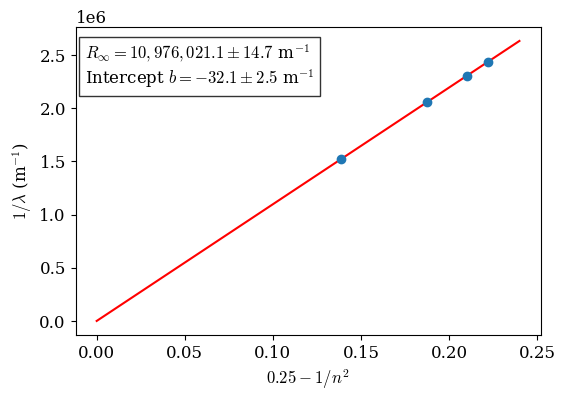

In [ ]:
n     = np.array([3, 4, 5, 6])                           # Hα, Hβ, Hγ

# ---- Build linearized variables ----
x = 0.25 - 1.0 / (n**2)       # dimensionless
lam_m = lamH * 1e-10     # m
y = 1.0 / lam_m               # m^-1

# propagate λ errors to y:  y = 1/λ  =>  σ_y = σ_λ / λ^2
if sig_lamH is not None:
    sigma_y = (sig_lamH * 1e-10) / (lam_m**2)
else:
    sigma_y = None

def linear_model(x, a, b):
    return a*x + b

popt, pcov = curve_fit(
    linear_model, x, y,
    sigma=sigma_y, absolute_sigma=(sigma_y is not None)
)
R_H, b = popt
sR_H, s_b = np.sqrt(np.diag(pcov))

# Convert to the infinite-mass Rydberg using reduced-mass correction
mu_H = (m_e * m_p) / (m_e + m_p)
R_inf = R_H * (m_e / mu_H)        # = R_H * (1 + m_e/m_p)
sR_inf = sR_H * (m_e / mu_H)

print(f"R_H     = {R_H:,.1f} ± {sR_H:,.1f} m^-1")
print(f"R_infty = {R_inf:,.1f} ± {sR_inf:,.1f} m^-1")
print(f"Intercept b = {b:.1f} ± {s_b:.1f} m^-1")

# plot data + fit
plt.figure(figsize=(6,4))
plt.errorbar(x, y, yerr=sigma_y, fmt='o', label="Data", capsize=3)
xf = np.linspace(0, 0.24, 100)
yf = linear_model(xf, *popt)
plt.plot(xf, yf, 'r-', label="Linear fit")
plt.xlabel(r"$0.25 - 1/n^2$")
plt.ylabel(r"$1/\lambda$ (m$^{-1}$)")

# annotate text with fit results
plt.text(0.02, 0.95,
         (f"$R_\\infty = {R_inf:,.1f} \\pm {sR_inf:,.1f}$ m$^{{-1}}$\n"
          f"Intercept $b = {b:.1f} \\pm {s_b:.1f}$ m$^{{-1}}$"),
         ha="left", va="top", transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))
